# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

# NMA Provided Codes

## Dataset Information

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [2]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

subjects = np.loadtxt('subjects_list.txt', dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)

## Region information

In [3]:
regions = np.load(f"regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

## Helpers

In [4]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    ev_file  = f"subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list

---

# Analysis

## Define Areas

In [72]:
"""
Note that these regions are present in the separately for right and left
So use R_ or L_ before these to get the necessary data
Define labels for areas
"""
DLPFC_LABELS = ["8C", "8Av", "i6-8", "s6-8", "SFL", "8BL", "9p", "9a", "8Ad", "p9-46v", "a9-46v", "46", "9-46d"]
PFC_LABELS = ['R_'+i for i in DLPFC_LABELS]
PFC_LABELS += ['L_'+i for i in DLPFC_LABELS]
FFC_LABELS = ['R_FFC', 'L_FFC']
BODY_LABELS = ['R_VVC', 'L_VVC']
PARA_LABELS = ["PHA3", "STSda", "V4t"]
PPA_LABELS = ['R_'+i for i in PARA_LABELS]
PPA_LABELS += ['L_'+i for i in PARA_LABELS]
LOC_LABELS = ['R_VMV2', 'L_VMV2']

LABELS = {
    'PFC': PFC_LABELS,
    'FFC': FFC_LABELS,
    'BODY': BODY_LABELS,
    'PPA': PPA_LABELS,
    'LOC': LOC_LABELS
}

## Some more helper methods

In [64]:
def get_area_data(data, area):
    """Returns the data for a given area label"""
    area_idx = np.where(regions[0] == area)[0] # Get area indices
    return data[area_idx, :] # Get that area from the data and return

def get_area_mean(data, areas):
    mean = []
    for area in areas:
        mean.append(get_area_data(data, area))
    return np.array(mean).mean(axis=0)

def get_ev_indices(exp, cond):
    """Returns the condition (time) indices relating to fMRI data"""
    return EXPERIMENTS[exp]['cond'].index(cond)

def get_cond_related_signal(data, evs, idx):
    return data[:, evs[idx]]

def get_all_subject_data(exp, cond, area_labels='whole_brain', remove_first_n=0, take_mean=False):
    """
    If take_mean, mean is taken across all subjects, so a single timeseries is returned.
    """
    all_data = []
    for s in subjects: # For all subjects
        for r in [0, 1]: # For all runs
            # Get data and event indices
            data = load_single_timeseries(subject=s, experiment=exp,
                                          run=r, remove_mean=True)
            evs = load_evs(subject=s, experiment=exp,run=r)
            
            idx = get_ev_indices(exp, cond)
            
            if area_labels=='whole_brain':
                whole_brain_data = get_cond_related_signal(data, evs, idx)
                all_data.append(whole_brain_data.mean(axis=0)[0][remove_first_n:])
            else: # If area labels are specified, take mean across those areas first
                area_data = get_area_mean(data, area_labels)
                all_data.append(get_cond_related_signal(area_data, evs, idx)[0][0][remove_first_n:])
    
    all_data = np.array(all_data)
    if take_mean:
        return all_data.mean(axis=0)
    else:
        return all_data
    
def get_contrast(exp, cond1, cond2, area_labels='whole_brain', remove_first_n=0, take_mean=False):
    cond1_data = get_all_subject_data(exp, cond1, area_labels, remove_first_n, take_mean)
    cond2_data = get_all_subject_data(exp, cond2, area_labels, remove_first_n, take_mean)
    return cond1_data-cond2_data

For example to get FFC region for 2 back faces task in working memory experiment while also removing the first 4 TRs (for instruction phase reasons), we can use the method below. From the length, we can see we got 200; 100 subjects with 2 runs each. 

In [53]:
get_all_subject_data('WM', '2bk_faces', area_labels=FFC_LABELS, remove_first_n=4).shape

(200, 35)

We could use take_mean=True to get the mean signal across subjects. This should give length of 35 since there are 39 TRs but we are removing the first 4.

In [27]:
get_all_subject_data('WM', '2bk_faces', area_labels=FFC_LABELS, remove_first_n=4, take_mean=True).shape

(35,)

Taking contrast would look like below, where I take the contrast for 2 back and 0 back faces conditions for whole brain (by not specifying any areas), also removing first 4 TRs and taking the mean.

In [66]:
get_contrast('WM', '2bk_faces', '0bk_faces', remove_first_n=4, take_mean=True)

array([-4.49889025, -6.04126541, -5.8394934 , -4.59264618, -0.23759149,
        1.70930784,  0.99464609,  2.310294  ,  3.99167385,  2.96786349,
        0.05812199, -1.94794242, -2.47390627, -4.53639317, -4.59921183,
       -4.27868972, -4.10467697, -7.50901002, -6.44455602, -8.48221506,
       -7.38079549, -5.91040796, -6.51116918, -4.20431531, -2.77005139,
       -2.06422395, -2.40791929,  0.42314962, -0.5661808 , -1.1374517 ,
        0.97482846,  1.06219228,  1.88479035,  1.50590096,  1.34684433])

## Plotting mean signals 

As a start, below I plot for all condition related regions and for only faces condition, mean signals across whole subjects and runs. Notice that -as expected- FFC region signal intensity is always higher than other regions, since I am plotting 2-back faces and 0-back faces conditions, where in both, pictures of faces are used as stimuli.

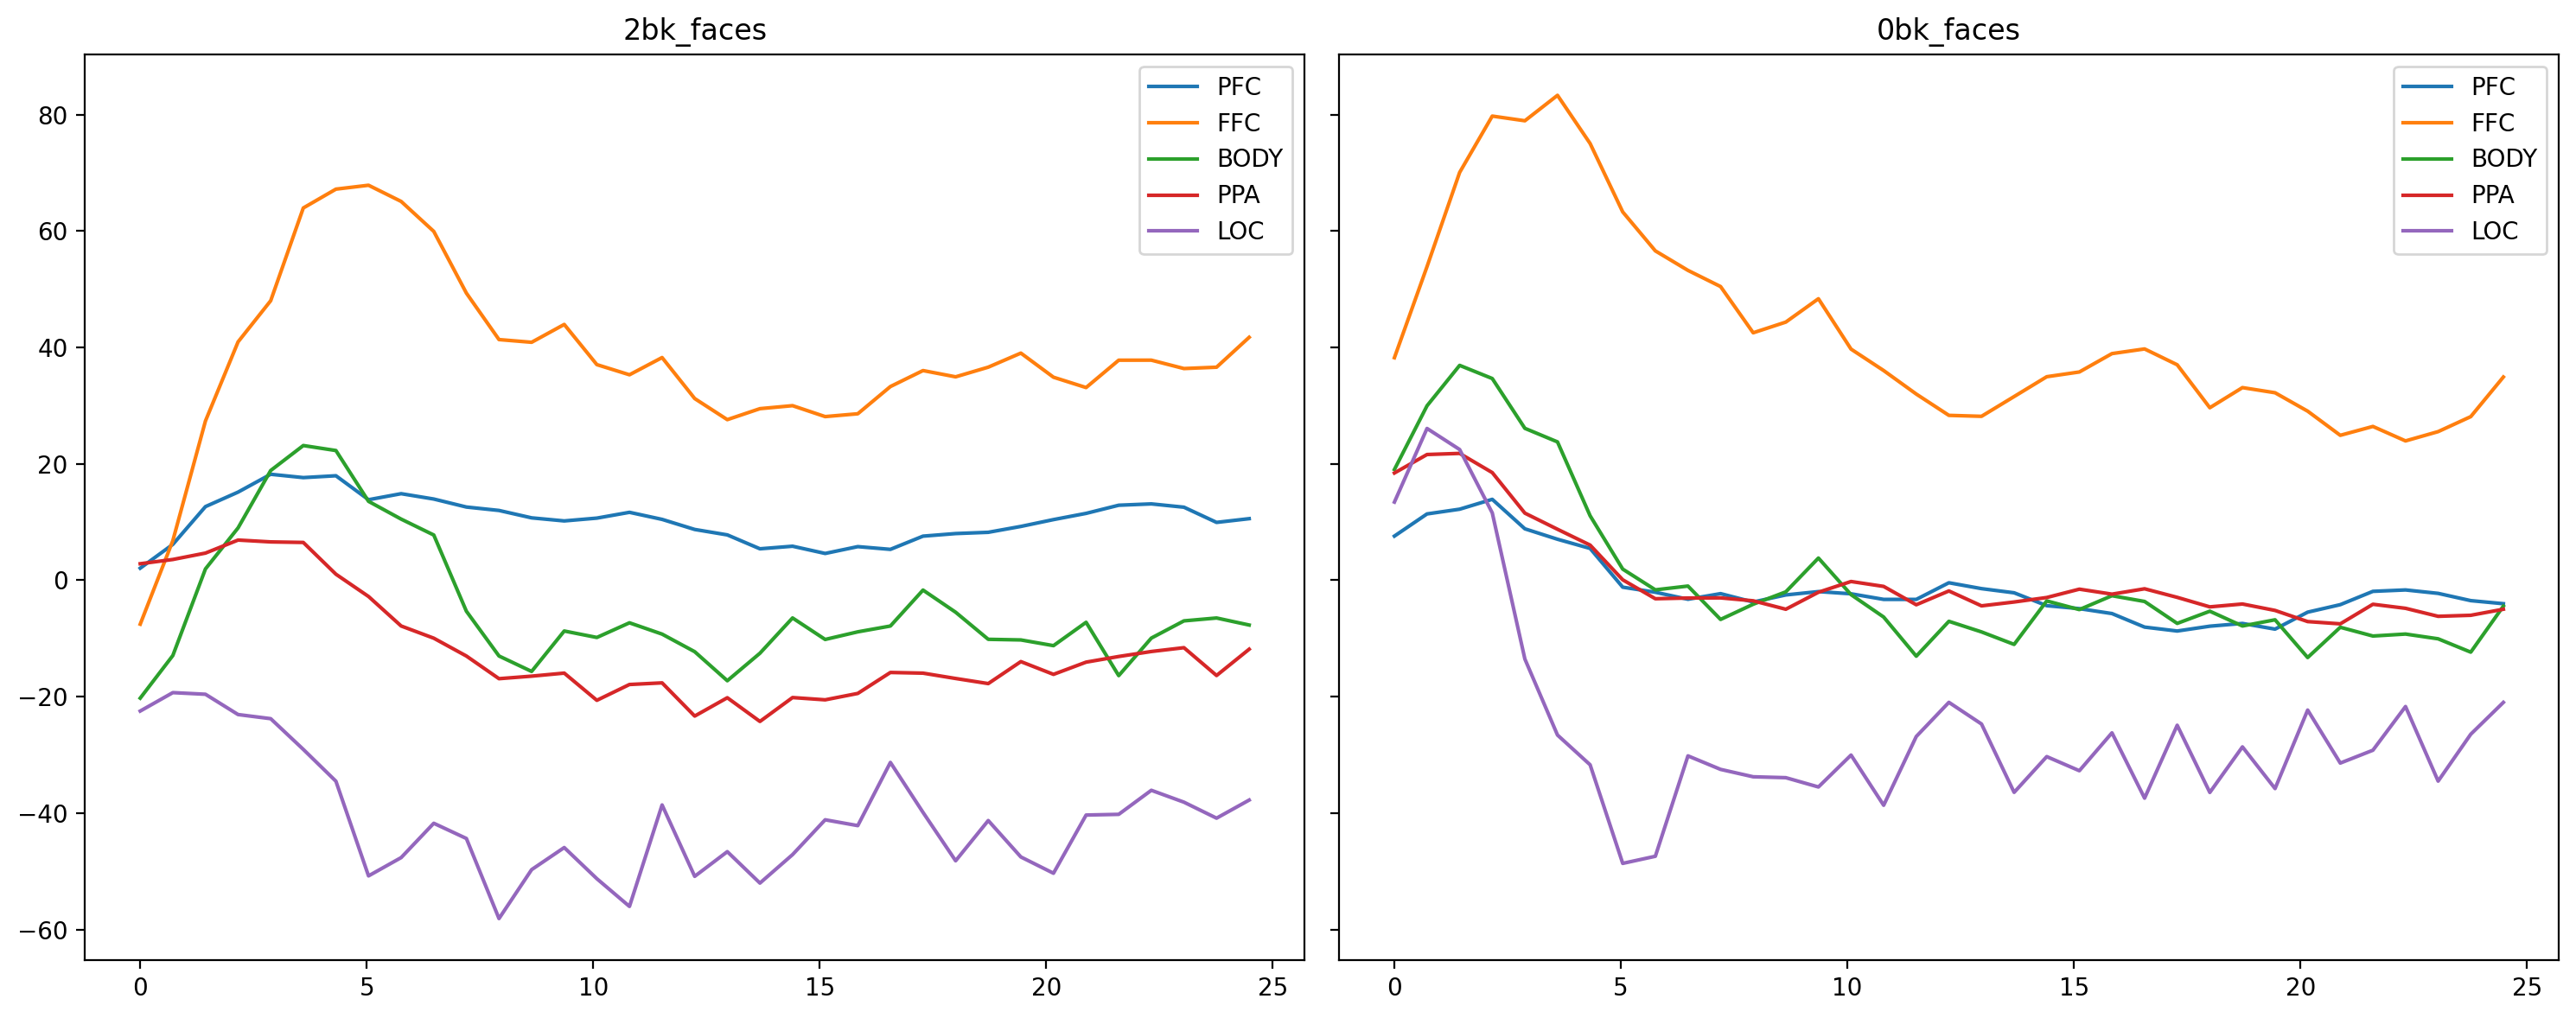

In [79]:
import matplotlib.pyplot as plt

secs = np.array(range(35))*0.72
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for region, labels in LABELS.items():
    data = get_all_subject_data('WM', '2bk_faces', labels, 4, True)
    axes[0].plot(secs, data, label=region)
    
    data = get_all_subject_data('WM', '0bk_faces', labels, 4, True)
    axes[1].plot(secs, data, label=region)
    
axes[0].set_title('2bk_faces')
axes[0].legend()
axes[1].set_title('0bk_faces')
axes[1].legend()
    
plt.tight_layout()
plt.show()

## PFC Signal Contrast for 2-back and 0-back Faces Task

Figure below shows the contrast for 2-back and 0-back PFC activation across all subjects and runs for faces condition. It can be seen that in the 2-back task, PFC is recruited more.

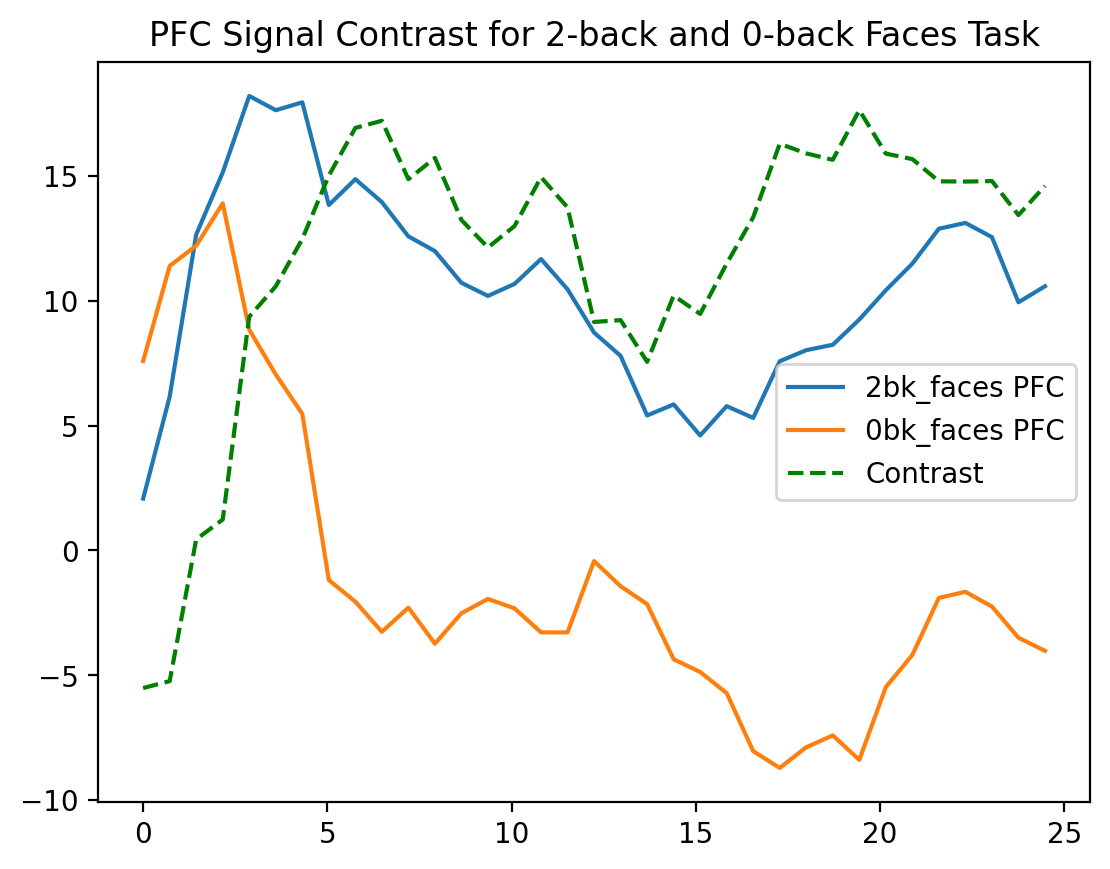

In [84]:
tmp1 = get_all_subject_data('WM', '2bk_faces', LABELS['PFC'], 4, True)
tmp2 = get_all_subject_data('WM', '0bk_faces', LABELS['PFC'], 4, True)

plt.plot(secs, tmp1, label='2bk_faces PFC')
plt.plot(secs, tmp2, label='0bk_faces PFC')
plt.plot(secs, tmp1-tmp2, 'g--', label='Contrast')
plt.title('PFC Signal Contrast for 2-back and 0-back Faces Task')
plt.legend()

## GLM Analysis

In the GLM analysis below, we see that only using the 2-back faces condition, face region signal mean and scene region signal mean are somewhat predictive of the pfc activations.

In [85]:
# dlPFCregion = betaFace * FFC + betaBody * BodyRegion + betaScene * SceneRegion + betaTool * ToolRegion + const

import statsmodels.api as sm

exp = 'WM'
cond = '2bk_faces'

pfc_2bkf = get_all_subject_data(exp, cond, LABELS['PFC'], 4, True)
ffc_2bkf = get_all_subject_data(exp, cond, LABELS['FFC'], 4, True)
body_2bkf = get_all_subject_data(exp, cond, LABELS['BODY'], 4, True)
ppa_2bkf = get_all_subject_data(exp, cond, LABELS['PPA'], 4, True)
loc_2bkf = get_all_subject_data(exp, cond, LABELS['LOC'], 4, True)

predictors = pd.DataFrame({
    'Face': ffc_2bkf,
    'Body': body_2bkf,
    'Scene': ppa_2bkf,
    'Tools': loc_2bkf
})

predictors = sm.add_constant(predictors)
model = sm.GLM(pfc_2bkf, predictors)

results = model.fit()

In [86]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:                            GLM   Df Residuals:                       30
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          3.5777
Method:                          IRLS   Log-Likelihood:                -69.273
Date:                Sun, 13 Aug 2023   Deviance:                       107.33
Time:                        22:34:35   Pearson chi2:                     107.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9614
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6310      1.852      1.961      0.050       0.002       7.260
Face           0.2333      0.049      4.754      0.000       0.137       0.330
Body          -0.0949      0.074     -1.278      0.201      -0.240       0.051
Scene          0.2354      0.076      3.110      0.002       0.087       0.384
Tools         -0.0071      0.065     -0.108      0.914      -0.135       0.121
==============================================================================
"""

## Generalization of GLM and Analysis on Faces Condition

Let me make a method to apply GLM on any given condition. This method will take experiment and condition and will apply GLM according to the formula

$$ dlPFCregion = \beta_{Face} * FFC + \beta_{Body} * BodyRegion + \beta_{Scene} * PPA + \beta_{Tool} * ToolRegion + const $$

In [94]:
def apply_glm(exp, cond, predict='PFC', remove_first_n=4):
    if predict == 'PFC':
        predict = get_all_subject_data(exp, cond, LABELS['PFC'], remove_first_n, True)
    else:
        pass
    ffc_cond = get_all_subject_data(exp, cond, LABELS['FFC'], remove_first_n, True)
    body_cond = get_all_subject_data(exp, cond, LABELS['BODY'], remove_first_n, True)
    ppa_cond = get_all_subject_data(exp, cond, LABELS['PPA'], remove_first_n, True)
    loc_cond = get_all_subject_data(exp, cond, LABELS['LOC'], remove_first_n, True)
    
    predictors = pd.DataFrame({
        'Face': ffc_cond,
        'Body': body_cond,
        'Scene': ppa_cond,
        'Tools': loc_cond
    })

    predictors = sm.add_constant(predictors)
    model = sm.GLM(predict, predictors)

    results = model.fit()
    
    return results.summary()

In [95]:
apply_glm('WM', '0bk_faces')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:                            GLM   Df Residuals:                       30
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          5.8793
Method:                          IRLS   Log-Likelihood:                -77.965
Date:                Sun, 13 Aug 2023   Deviance:                       176.38
Time:                        22:46:55   Pearson chi2:                     176.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9934
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5021      2.212     -1.583      0.113      -7.837       0.833
Face           0.1134      0.069      1.651      0.099      -0.021       0.248
Body           0.0163      0.156      0.105      0.916      -0.289       0.322
Scene          0.2797      0.217      1.288      0.198      -0.146       0.705
Tools          0.1050      0.064      1.643      0.100      -0.020       0.230
==============================================================================
"""

We can also give our own signal to predict. For example let's predict contrast of PFC from the defined regions above. For that purpose, in the cell below, I take the contrast and give to apply_glm method as arguement 'predict'. 

From the result, we see that contrast signal still is predicted poorly by 0-back condition signals. This is understandable though, as 0-back is not heavily dependent working memory processes.

In [96]:
pfc_2bkf = get_all_subject_data(exp, '2bk_faces', LABELS['PFC'], 4, True)
pfc_0bkf = get_all_subject_data(exp, '0bk_faces', LABELS['PFC'], 4, True)

apply_glm('WM', '0bk_faces', predict=pfc_2bkf-pfc_0bkf)

/tmp/ipykernel_8330/2347510979.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if predict == 'PFC':


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:                            GLM   Df Residuals:                       30
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          4.9349
Method:                          IRLS   Log-Likelihood:                -74.901
Date:                Sun, 13 Aug 2023   Deviance:                       148.05
Time:                        22:46:57   Pearson chi2:                     148.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9969
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9524      2.026      2.444      0.015       0.981       8.924
Face           0.1538      0.063      2.444      0.015       0.030       0.277
Body           0.0284      0.143      0.199      0.842      -0.251       0.308
Scene         -0.8478      0.199     -4.261      0.000      -1.238      -0.458
Tools         -0.0109      0.059     -0.186      0.853      -0.126       0.104
==============================================================================
"""

Predicting the contrast of PFC for 2-back faces condition gives better beta weight in face region, as seen below.

In [97]:
apply_glm('WM', '2bk_faces', predict=pfc_2bkf-pfc_0bkf)

/tmp/ipykernel_8330/2347510979.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if predict == 'PFC':


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:                            GLM   Df Residuals:                       30
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          8.3172
Method:                          IRLS   Log-Likelihood:                -84.036
Date:                Sun, 13 Aug 2023   Deviance:                       249.52
Time:                        22:49:46   Pearson chi2:                     250.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9542
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9608      2.823     -1.757      0.079     -10.495       0.573
Face           0.3635      0.075      4.858      0.000       0.217       0.510
Body          -0.1531      0.113     -1.352      0.176      -0.375       0.069
Scene         -0.3352      0.115     -2.904      0.004      -0.561      -0.109
Tools          0.0459      0.099      0.462      0.644      -0.149       0.241
==============================================================================
"""

## GLM on Places Condition

In the places condition, the contrast signal of PFC is predicted much better from the category related region, scene region.

In [105]:
pfc_2bkp = get_all_subject_data(exp, '2bk_places', LABELS['PFC'], 4, True)
pfc_0bkp = get_all_subject_data(exp, '0bk_places', LABELS['PFC'], 4, True)

apply_glm('WM', '2bk_places', predict=pfc_2bkp-pfc_0bkp)

/tmp/ipykernel_8330/2347510979.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if predict == 'PFC':


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:                            GLM   Df Residuals:                       30
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          25.228
Method:                          IRLS   Log-Likelihood:                -103.45
Date:                Sun, 13 Aug 2023   Deviance:                       756.85
Time:                        22:56:59   Pearson chi2:                     757.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.5999
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4958      5.321     -0.093      0.926     -10.925       9.933
Face           0.6770      0.300      2.260      0.024       0.090       1.264
Body          -0.3250      0.144     -2.253      0.024      -0.608      -0.042
Scene         -1.0420      0.333     -3.130      0.002      -1.695      -0.390
Tools          0.4373      0.106      4.143      0.000       0.230       0.644
==============================================================================
"""

## GLM on Body Condition

Similarly, body region signal have important weight for predicting PFC contrast signal on body condition of working memory experiment. Interestingly, face region also has a high beta value.

In [106]:
pfc_2bkb = get_all_subject_data(exp, '2bk_body', LABELS['PFC'], 4, True)
pfc_0bkb = get_all_subject_data(exp, '0bk_body', LABELS['PFC'], 4, True)

apply_glm('WM', '2bk_body', predict=pfc_2bkb-pfc_0bkb)

/tmp/ipykernel_8330/2347510979.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if predict == 'PFC':


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   35
Model:                            GLM   Df Residuals:                       30
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                          96.374
Method:                          IRLS   Log-Likelihood:                -126.91
Date:                Sun, 13 Aug 2023   Deviance:                       2891.2
Time:                        22:57:45   Pearson chi2:                 2.89e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7269
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.4587      7.134     -2.868      0.004     -34.441      -6.477
Face           1.6339      0.425      3.844      0.000       0.801       2.467
Body          -1.5681      0.572     -2.741      0.006      -2.689      -0.447
Scene         -0.8407      0.553     -1.520      0.129      -1.925       0.243
Tools          0.1859      0.299      0.622      0.534      -0.400       0.772
==============================================================================
"""